In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from climtas.nci import GadiClient
from sea_breeze.sea_breeze_funcs import kinematic_frontogenesis
import metpy.calc as mpcalc
import metpy.units as units
from sea_breeze.load_model_data import load_aus2200_static, load_aus2200_variable

In [2]:
GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38789,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:45679,Total threads: 1
Dashboard: /proxy/40803/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36571,


In [3]:
def load_aus2200_static(exp_id,lon_slice,lat_slice):

    '''
    Load static fields for the mjo-enso AUS2200 experiment, stored on the ua8 project

    ## Input
    * exp_id: string describing the experiment. either 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'

    * lat_slice: a slice to restrict lat domain

    * lon_slice: a slice to restrict lon domain
    '''

    assert exp_id in ['mjo-elnino', 'mjo-lanina', 'mjo-neutral'], "exp_id must either be 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'"
    
    orog = xr.open_dataset("/g/data/ua8/AUS2200/"+exp_id+"/v1-0/fx/orog/orog_AUS2200_"+exp_id+"_fx.nc").\
            sel(lat=lat_slice,lon=lon_slice)
    lsm = xr.open_dataset("/g/data/ua8/AUS2200/"+exp_id+"/v1-0/fx/lmask/lmask_AUS2200_"+exp_id+"_fx.nc").\
            sel(lat=lat_slice,lon=lon_slice)

    return orog.orog, lsm.lmask



In [4]:
lat_slice=slice(-40,-30)
lon_slice=slice(110,120)
t1="2016-01-21 12:00"
t2="2016-01-22 12:00"

In [5]:
orog, lsm = load_aus2200_static("mjo-elnino",lon_slice,lat_slice)
aus2200_sfc = load_aus2200_variable(["vas","uas","hus"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"10min")

In [6]:
#aus2200_ml = load_aus2200_variable(["ua","va"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"1hr",hgt_slice=slice(0,5000))

In [7]:
#aus2200_wind = xr.Dataset({"u":aus2200_ml["ua"].ua, "v":aus2200_ml["va"].va})

In [9]:
def destagger_aus2200(ds_dict,destag_list,interp_to=None,lsm=None):

    """
    
    From a dictionary of aus2200 datasets (output from load_aus2200_variable), destagger variables in destag_list by interpolating
    
    ## Input
    * ds_dict: a dictionary of aus2200 xarray datasets. output from load_aus2200_variable()

    * destag_list: list of variables to destagger

    * interp_to: variable for which to use spatial info to interp onto

    * lsm: land sea mask dataset to interp on to

    ## Output
    a dictionary of datasets with destaggered variables

    ## Example
    destagger_aus2200(ds_dict, ["uas","vas"], "hus")

    """

    for vars in destag_list:
        if interp_to is not None:
            ds_dict[vars] = ds_dict[vars].interp_like(ds_dict[interp_to],method="linear").compute()
        elif lsm is not None:
            ds_dict[vars] = ds_dict[vars].interp_like(lsm,method="linear").compute()
        else:
            raise Exception("Need to input either a variable to interp to, or a land sea mask, to get spatial info")
        
    return ds_dict

aus2200_sfc = destagger_aus2200(aus2200_sfc,["uas","vas"],interp_to="hus",lsm=None)

In [10]:
q = aus2200_sfc["hus"]["hus"].isel(time=0)
u = aus2200_sfc["uas"]["uas"].isel(time=0)
v = aus2200_sfc["vas"]["vas"].isel(time=0)
# u = aus2200_wind.u.isel(time=0,lev=0)
# v = aus2200_wind.v.isel(time=0,lev=0)

Fq = mpcalc.frontogenesis(q*units.units("K"),
                        u,
                        v) * 1.08e9

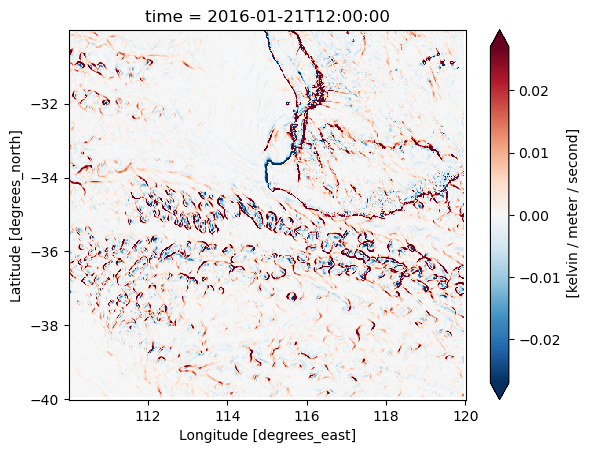

In [12]:
Fq.plot(robust=True)